<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

In [ ]:
from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    unfreeze_last_l_blocks = 1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = True
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
for l in range(1,6):
    baseline_params.unfreeze_last_l_blocks = l
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(baseline_params)

    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

    # Second plot: Rerun training multiple times with different seed
    run_with_different_seeds(baseline_params, trials=3)

    # Third plot: Compare NAG with Adam
    experimental_params = baseline_params.copy()
    experimental_params.optimizer = AdamParams(learning_rate=0.001)
    
    param_sets = {
        "Baseline (NAG)": baseline_params,
        "Experiment (Adam)": experimental_params,
    }
    
    run_comparison(param_sets, trials=3)


# Train unsupervised model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "pseudo_threshold": 0.95,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Training result:
{
  "training_losses": [2.8090842048373776, 0.5579158417246444, 0.26435716466066683, 0.15356437947125512, 0.14357572975271243, 0.09260864983352417, 0.04366252684787391, 0.03026265555749984, 0.058542964880929346, 0.04261946814640009],
  "training_accuracies": [0.6009327115256495, 0.8774150566289141, 0.9467021985343105, 0.9680213191205863, 0.9700199866755497, 0.9806795469686875, 0.9906728847435043, 0.9966688874083944, 0.9893404397068621, 0.9913391072618255],
  "validation_accuracies": [0.85190217391

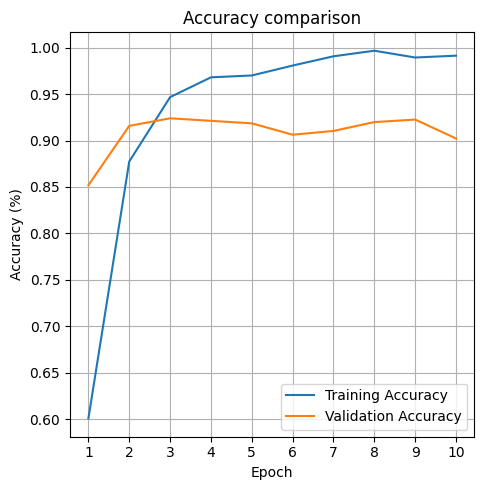

In [2]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
   
dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    labelled_data_fraction=0.51, # full labelled data first
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.022630885203465553,
        weight_decay=8.478660307897792e-05,
        momentum=0.8063799868511693,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    unfreeze_last_l_blocks = 3,
    pseudo_threshold = 0.95
)

run_args = (dataset_params, baseline_params)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 4.1206, Train Acc: 40.35%, Val Acc: 80.71%
Epoch [2/10], Loss: 1.2974, Train Acc: 75.66%, Val Acc: 88.59%
Epoch [3/10], Loss: 0.4117, Train Acc: 91.78%, Val Acc: 87.64%
Epoch [4/10], Loss: 0.3070, Train Acc: 94.19%, Val Acc: 89.95%
Epoch [5/10], Loss: 0.2057, Train Acc: 96.16%, Val Acc: 87.91%
Epoch [6/10], Loss: 0.1239, Train Acc: 97.92%, Val Acc: 87.77%
Epoch [7/10], Loss: 0.1132, Train Acc: 97.15%, Val Acc: 87.77%
Epoch [8/10], Loss: 0.1514, Train Acc: 97.26%, Val Acc: 88.45%
Epoch [9/10], Loss: 0.1324, Train Acc: 98.03%, Val Acc: 86.28%
Epoch [10/10], Loss: 0.0837, Train Acc: 98.25%, Val Acc: 86.14%
Total elapsed: 174.97s, average per update step: 0.12s
[Trainer] Saved checkpoint to runs/checkpoints/0e1ee255902cd92ac26540f30740ae22.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.2138, Train Acc: 66.03%, Val Acc: 88.04%
Epoch [2/10], Loss: 0.3846, Train Acc: 90.48%, Val Acc: 90.49%
Epoch [3/10], Loss: 0.1167, Train Acc: 97.32%, Val Acc: 92.80%
Epoch [4/10], Loss: 0.0628, Train Acc: 98.52%, Val Acc: 93.07%
Epoch [5/10], Loss: 0.0423, Train Acc: 99.23%, Val Acc: 93.34%
Epoch [6/10], Loss: 0.0242, Train Acc: 99.62%, Val Acc: 93.07%
Epoch [7/10], Loss: 0.0215, Train Acc: 99.47%, Val Acc: 93.48%
Epoch [8/10], Loss: 0.0120, Train Acc: 99.90%, Val Acc: 94.16%
Epoch [9/10], Loss: 0.0108, Train Acc: 99.76%, Val Acc: 93.75%
Epoch [10/10], Loss: 0.0056, Train Acc: 99.95%, Val Acc: 94.43%
Total elapsed: 157.70s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/efc5b4a85f074359154fd086febbaec9.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.8359, Train Acc: 70.81%, Val Acc: 89.13%
Epoch [2/10], Loss: 0.3109, Train Acc: 91.04%, Val Acc: 91.85%
Epoch [3/10], Loss: 0.0846, Train Acc: 97.46%, Val Acc: 92.12%
Epoch [4/10], Loss: 0.0399, Train Acc: 99.33%, Val Acc: 94.57%
Epoch [5/10], Loss: 0.0202, Train Acc: 99.66%, Val Acc: 94.57%
Epoch [6/10], Loss: 0.0116, Train Acc: 99.85%, Val Acc: 93.75%
Epoch [7/10], Loss: 0.0103, Train Acc: 99.81%, Val Acc: 94.84%
Epoch [8/10], Loss: 0.0114, Train Acc: 99.66%, Val Acc: 93.48%
Epoch [9/10], Loss: 0.0065, Train Acc: 99.96%, Val Acc: 93.61%
Epoch [10/10], Loss: 0.0075, Train Acc: 99.93%, Val Acc: 94.29%
Total elapsed: 148.28s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/91578b7ce446d7f79d23314d1bc1b1ac.pth


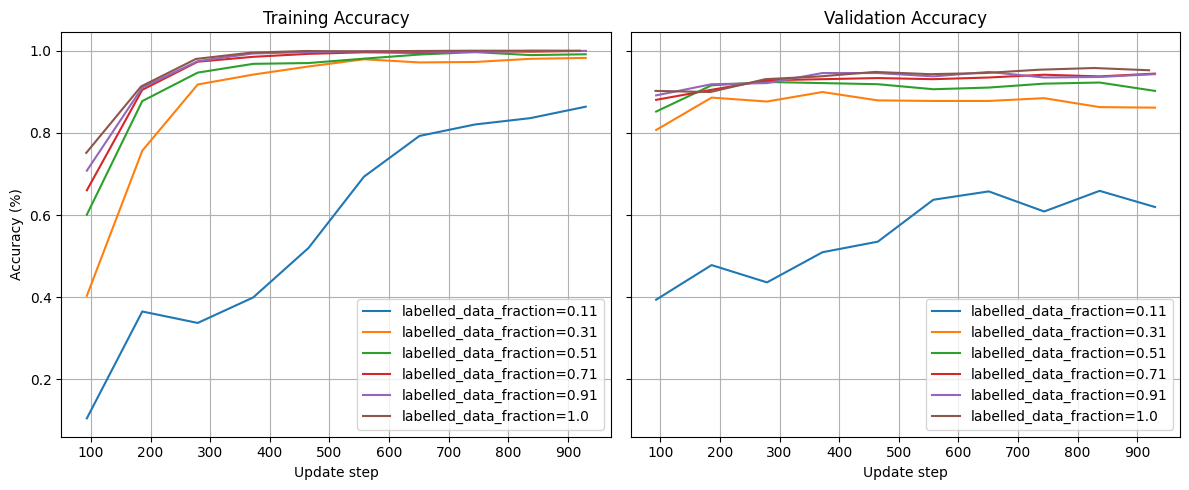

In [3]:
from evaluation import run_dataset_comparison

def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params
 
#plot: Compare unsupervised learning for different fractions of unlabelled data
labelled_data_fractions = [ 0.11, 0.31, 0.51, 0.71, 0.91, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

run_dataset_comparison(param_sets, baseline_params)


# Test model

In [ ]:
from training import FinishedAllEpochs, Trainer
from datasets import make_datasets, load_dataset
from torch.utils.data import DataLoader

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer = Trainer(training_params)
labelled_train_loader, unlabelled_train_loader, val_loader = make_datasets(dataset_params, trainer.transform)
trainer.load_dataset(labelled_train_loader, unlabelled_train_loader, val_loader)
trainer.train(stop_condition=FinishedAllEpochs())

training_params.data_augmentation = "false"
test_dataset = load_dataset("test", Trainer.make_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)